# Setup and Import

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Set save paths
project_dir = r'C:\Shopper spectrum Project'
model_dir = os.path.join(project_dir, 'models')
output_dir = os.path.join(project_dir, 'outputs')

os.makedirs(model_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Load & Clean Data

In [7]:
# Load data
df = pd.read_csv(r"C:\Shopper spectrum Project\online_retail.csv", encoding='ISO-8859-1')

# Remove cancellations
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Drop rows with missing customer IDs
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Filter out negative or zero TotalAmount
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [19]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60


# EDA Exploratory Data Analysis

## 1. Transaction trends over time

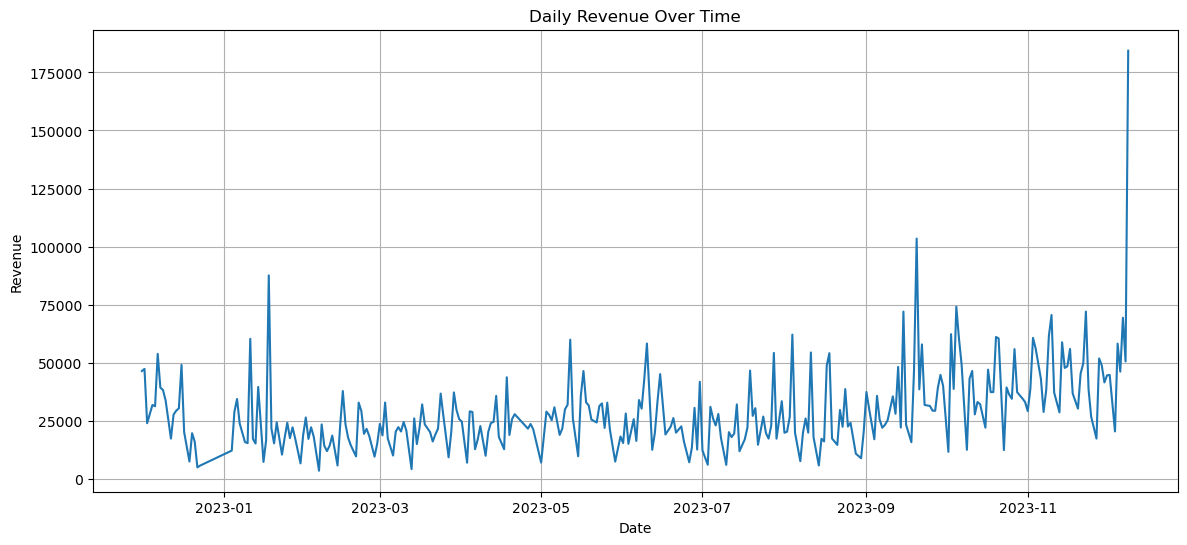

In [25]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Daily total revenue
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
daily_sales.plot()
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid()
plt.show()

## 2. Transaction Volume by country

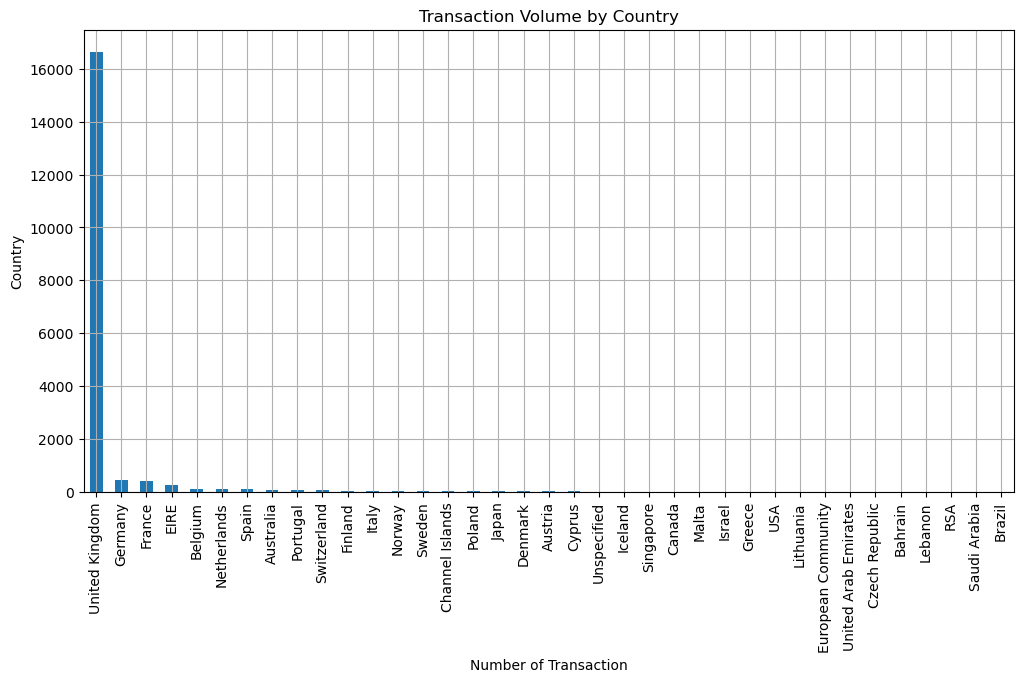

In [28]:
tx_per_country = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

plt.figure(figsize=(12,6))
tx_per_country.plot(kind='bar')
plt.title("Transaction Volume by Country")
plt.xlabel("Number of Transaction")
plt.ylabel("Country")
plt.xticks(rotation=90)
plt.grid()
plt.show()

## 3. Identify Top-Selling Products

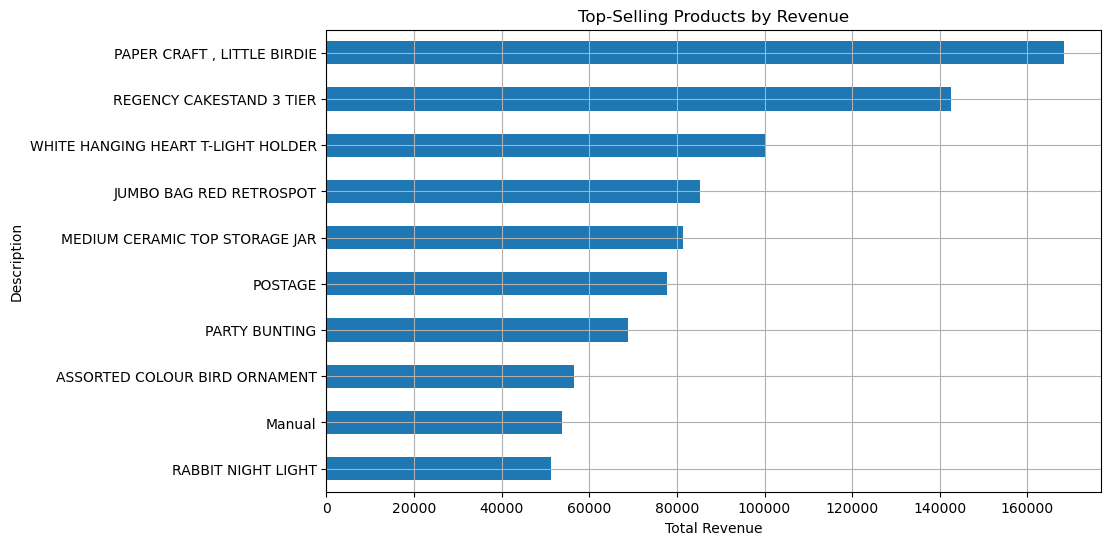

In [31]:
top_products = df.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
top_products.plot(kind='barh')
plt.title("Top-Selling Products by Revenue")
plt.xlabel("Total Revenue")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

## 4. Inspect Monetary Distribution per Transaction and Customer

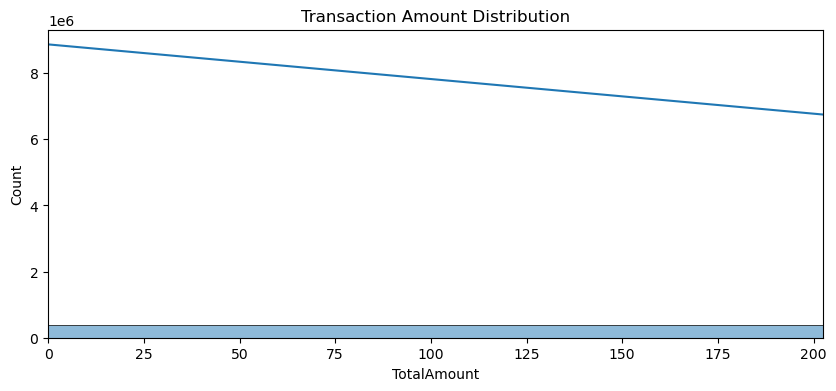

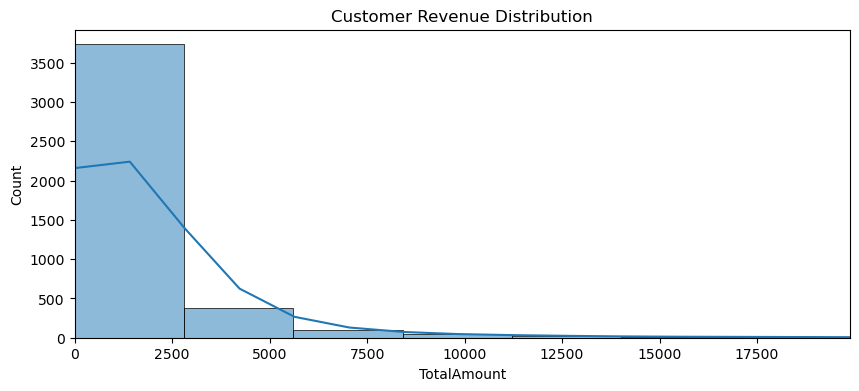

In [34]:
# Distribution of transaction amounts
plt.figure(figsize=(10,4))
sns.histplot(df['TotalAmount'], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlim(0, df['TotalAmount'].quantile(0.99))
plt.show()

# Customer-level revenue distribution
customer_revenue = df.groupby('CustomerID')['TotalAmount'].sum()

plt.figure(figsize=(10,4))
sns.histplot(customer_revenue, bins=100, kde=True)
plt.title("Customer Revenue Distribution")
plt.xlim(0, customer_revenue.quantile(0.99))
plt.show()

## 5. RFM Distributions

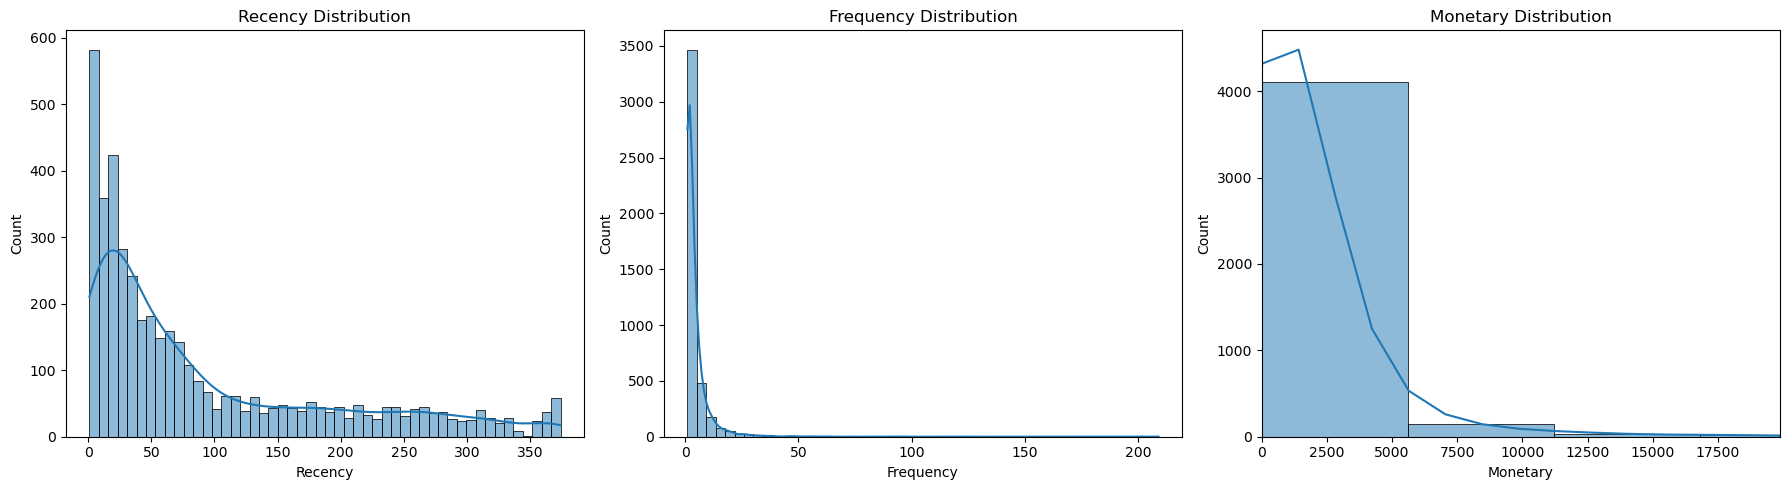

In [37]:
import datetime
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

# Plot RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=50, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')
axes[2].set_xlim(0, rfm['Monetary'].quantile(0.99))

plt.tight_layout()
plt.show()

## 6. Elbow Curve for Cluster Selection

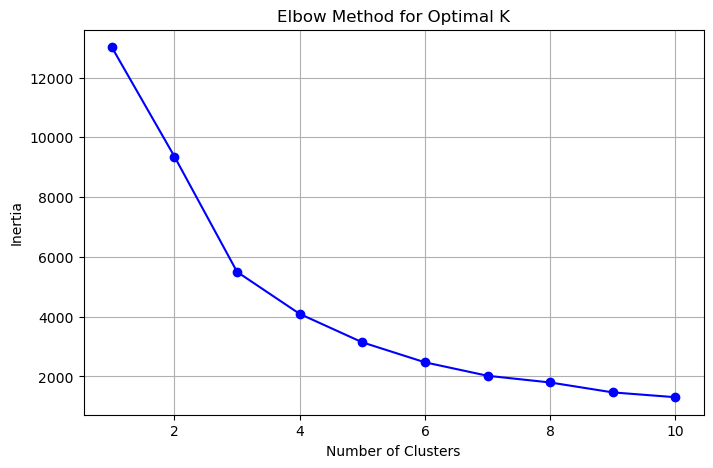

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

## 7. Customer Cluster Profiles

In [45]:
optimal_k = 4  # or whatever you choose based on elbow
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_profile)

        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          43.7       3.7    1359.0  3054
1         248.1       1.6     480.6  1067
2           7.4      82.5  127338.3    13
3          15.5      22.3   12709.1   204


# RFM Feature Engineering

In [11]:
# Reference date for recency
ref_date = df['InvoiceDate'].max() + timedelta(days=1)

# Compute RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Scale RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Cluster
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Save scaler, model, and RFM CSV
joblib.dump(scaler, os.path.join(model_dir, 'rfm_scaler.pkl'))
joblib.dump(kmeans, os.path.join(model_dir, 'kmeans_model.pkl'))
rfm.to_csv(os.path.join(output_dir, 'rfm_clusters.csv'), index=False)

#  Item-Based Collaborative Filtering

In [13]:
# Build customer-product matrix
user_product_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)

# Compute cosine similarity between products
product_similarity_df = pd.DataFrame(
    cosine_similarity(user_product_matrix.T),
    index=user_product_matrix.columns,
    columns=user_product_matrix.columns
)

# Map product codes to names
product_names = df[['StockCode', 'Description']].drop_duplicates().dropna()
product_names = product_names.groupby('StockCode')['Description'].first()

# Save both
joblib.dump(product_similarity_df, os.path.join(model_dir, 'product_similarity.pkl'))
joblib.dump(product_names, os.path.join(model_dir, 'product_names.pkl'))

['C:\\Shopper spectrum Project\\models\\product_names.pkl']